# Visibility Prediction using METAR Data
This notebook trains a regression model to predict visibility from METAR weather observations.

In [3]:
# Import required libraries
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Load the METAR dataset
df = pd.read_csv('datasets/metar.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2343, 30)


,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,OOA,2026-01-01 00:15,38.7,35.0,86.41,290.0,3.0,0.0,29.93,M,...,M,M,M,M,M,M,M,36.35,KOOA 010015Z AUTO 29003KT 10SM CLR 04/02 A2993...,M
1,OOA,2026-01-01 00:35,38.0,34.7,87.76,300.0,4.0,0.0,29.94,M,...,M,M,M,M,M,M,M,34.43,KOOA 010035Z AUTO 30004KT 10SM CLR 03/02 A2994...,M
2,OOA,2026-01-01 00:55,36.5,34.0,90.54,320.0,4.0,0.0,29.94,M,...,M,M,M,M,M,M,M,32.68,KOOA 010055Z AUTO 32004KT 10SM CLR 03/01 A2994...,M
3,OOA,2026-01-01 01:15,37.0,34.7,91.29,320.0,4.0,0.0,29.94,M,...,M,M,M,M,M,M,M,33.26,KOOA 010115Z AUTO 32004KT 10SM CLR 03/02 A2994...,M
4,OOA,2026-01-01 01:35,39.4,36.0,87.49,350.0,10.0,0.0,29.96,M,...,M,M,M,M,M,M,M,32.25,KOOA 010135Z AUTO 35010KT 10SM CLR 04/02 A2996...,M


In [5]:
# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station            2343 non-null   object 
 1   valid              2343 non-null   object 
 2   tmpf               2343 non-null   float64
 3   dwpf               2343 non-null   float64
 4   relh               2343 non-null   float64
 5   drct               2343 non-null   float64
 6   sknt               2343 non-null   float64
 7   p01i               2343 non-null   float64
 8   alti               2343 non-null   float64
 9   mslp               2343 non-null   object 
 10  vsby               2343 non-null   float64
 11  gust               2343 non-null   object 
 12  skyc1              2343 non-null   object 
 13  skyc2              2343 non-null   object 
 14  skyc3              2343 non-null   object 
 15  skyc4              2343 non-null   object 
 16  skyl1    

In [6]:
# Statistical summary of numerical features
df.describe()

,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,feel
count,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000
mean,23.867691,15.616090,71.701767,222.936406,9.471191,0.000551,30.125058,9.164426,14.120563
std,14.016100,15.796053,15.430023,113.931747,5.555627,0.009923,0.290339,2.279222,17.717744
min,-9.600000,-26.000000,23.790000,0.000000,0.000000,0.000000,29.260000,0.250000,-34.750000
25%,12.700000,3.000000,62.545000,160.000000,5.500000,0.000000,29.920000,10.000000,-0.065000
50%,26.200000,17.000000,73.600000,260.000000,8.000000,0.000000,30.140000,10.000000,16.910000
75%,33.800000,29.300000,81.645000,310.000000,13.000000,0.000000,30.320000,10.000000,26.795000
max,60.000000,57.400000,100.000000,360.000000,34.000000,0.290000,30.830000,10.000000,60.000000


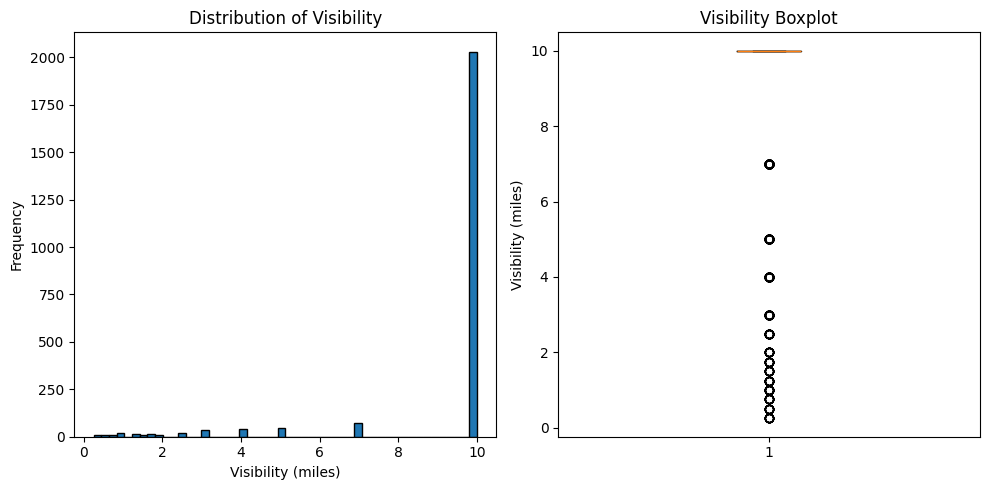

In [7]:
# Check visibility distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['vsby'].dropna(), bins=50, edgecolor='black')
plt.xlabel('Visibility (miles)')
plt.ylabel('Frequency')
plt.title('Distribution of Visibility')

plt.subplot(1, 2, 2)
plt.boxplot(df['vsby'].dropna())
plt.ylabel('Visibility (miles)')
plt.title('Visibility Boxplot')
plt.tight_layout()
plt.show()

In [8]:
# Data Preprocessing
# Select relevant features for visibility prediction
features = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'feel']

# Create a clean dataset with target variable (vsby) and features
data = df[features + ['vsby']].copy()

# Remove rows with missing values
print(f"\nRows before cleaning: {len(data)}")
data = data.dropna()
print(f"Rows after cleaning: {len(data)}")

# Separate features and target
X = data[features]
y = data['vsby']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Rows before cleaning: 2343
Rows after cleaning: 2343

Features shape: (2343, 8)
Target shape: (2343,)


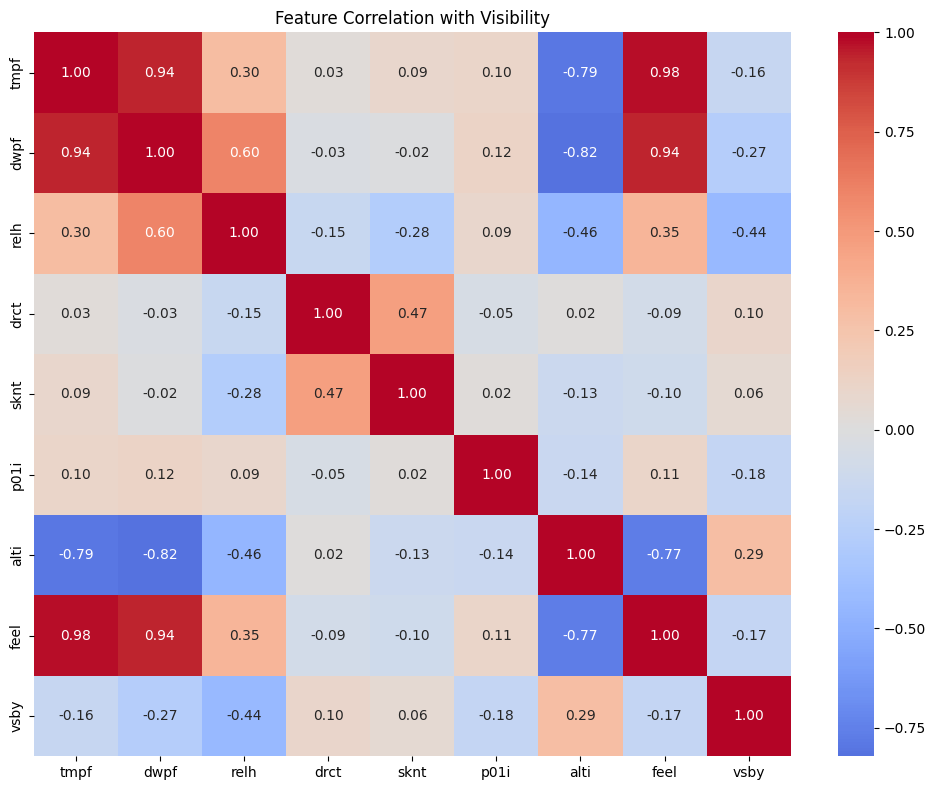


Correlation with Visibility:
vsby    1.000000
alti    0.289628
drct    0.099639
sknt    0.059971
tmpf   -0.158965
feel   -0.174838
p01i   -0.180579
dwpf   -0.271919
relh   -0.435247
Name: vsby, dtype: float64


In [9]:
# Correlation analysis
plt.figure(figsize=(10, 8))
correlation = data[features + ['vsby']].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation with Visibility')
plt.tight_layout()
plt.show()

print("\nCorrelation with Visibility:")
print(correlation['vsby'].sort_values(ascending=False))

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 1874
Testing set size: 469


In [11]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!


In [12]:
# Model 1: Linear Regression
print("Training Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"\nLinear Regression Results:")
print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R² Score: {lr_r2:.4f}")

Training Linear Regression Model...

Linear Regression Results:
RMSE: 1.8747
MAE: 1.2826
R² Score: 0.3482


In [13]:
# Model 2: Random Forest Regressor
print("Training Random Forest Model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"\nRandom Forest Results:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R² Score: {rf_r2:.4f}")

Training Random Forest Model...

Random Forest Results:
RMSE: 0.9760
MAE: 0.3749
R² Score: 0.8233


In [14]:
# Model 3: Gradient Boosting Regressor
print("Training Gradient Boosting Model...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

gb_mse = mean_squared_error(y_test, gb_pred)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

print(f"\nGradient Boosting Results:")
print(f"RMSE: {gb_rmse:.4f}")
print(f"MAE: {gb_mae:.4f}")
print(f"R² Score: {gb_r2:.4f}")

Training Gradient Boosting Model...

Gradient Boosting Results:
RMSE: 0.9968
MAE: 0.5046
R² Score: 0.8157


In [15]:
# Model Comparison
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'RMSE': [lr_rmse, rf_rmse, gb_rmse],
    'MAE': [lr_mae, rf_mae, gb_mae],
    'R² Score': [lr_r2, rf_r2, gb_r2]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results.to_string(index=False))
print("="*60)


MODEL COMPARISON
            Model     RMSE      MAE  R² Score
Linear Regression 1.874692 1.282575  0.348216
    Random Forest 0.976038 0.374935  0.823324
Gradient Boosting 0.996820 0.504612  0.815720


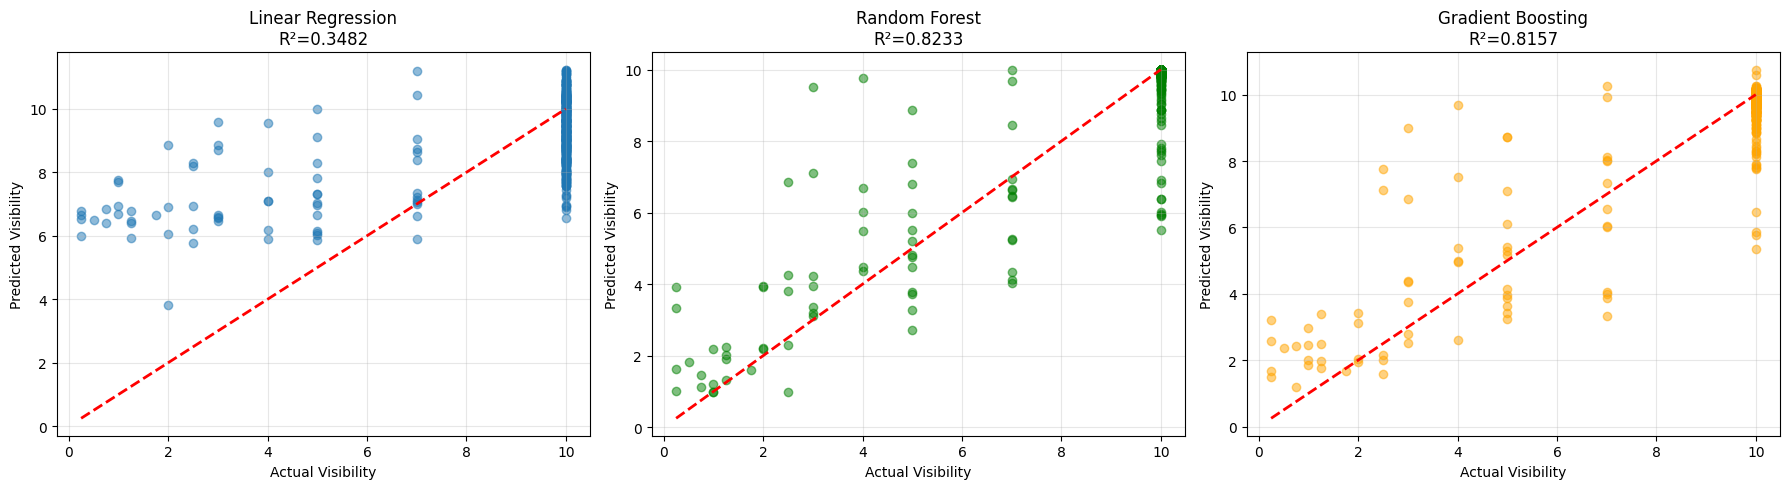

In [16]:
# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Linear Regression
axes[0].scatter(y_test, lr_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Visibility')
axes[0].set_ylabel('Predicted Visibility')
axes[0].set_title(f'Linear Regression\nR²={lr_r2:.4f}')
axes[0].grid(True, alpha=0.3)

# Random Forest
axes[1].scatter(y_test, rf_pred, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Visibility')
axes[1].set_ylabel('Predicted Visibility')
axes[1].set_title(f'Random Forest\nR²={rf_r2:.4f}')
axes[1].grid(True, alpha=0.3)

# Gradient Boosting
axes[2].scatter(y_test, gb_pred, alpha=0.5, color='orange')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Visibility')
axes[2].set_ylabel('Predicted Visibility')
axes[2].set_title(f'Gradient Boosting\nR²={gb_r2:.4f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

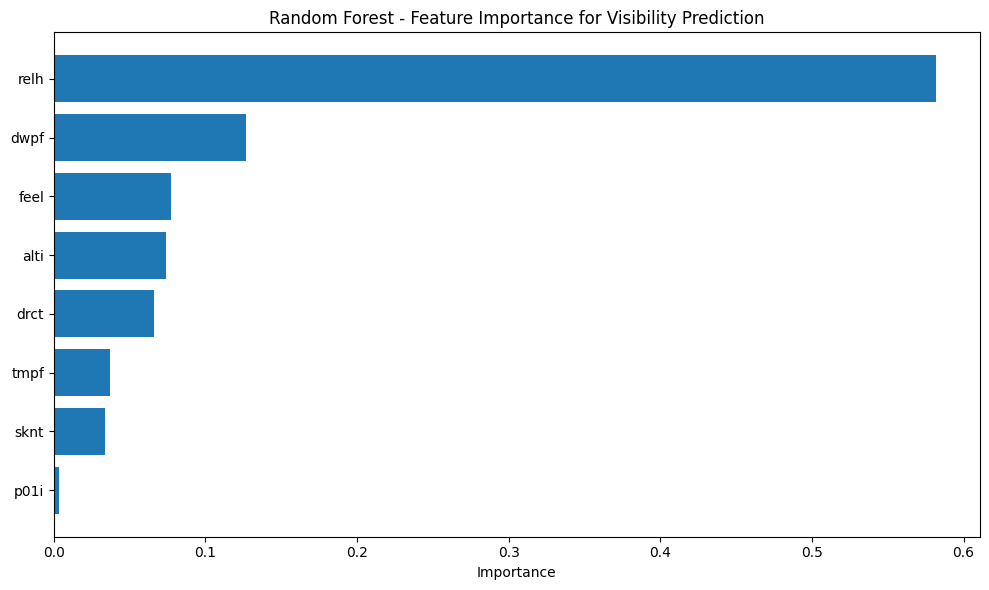


Feature Importance:
  Feature  Importance
2    relh    0.581724
1    dwpf    0.126526
7    feel    0.077177
6    alti    0.074222
3    drct    0.066286
0    tmpf    0.037266
4    sknt    0.033473
5    p01i    0.003325


In [17]:
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest - Feature Importance for Visibility Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

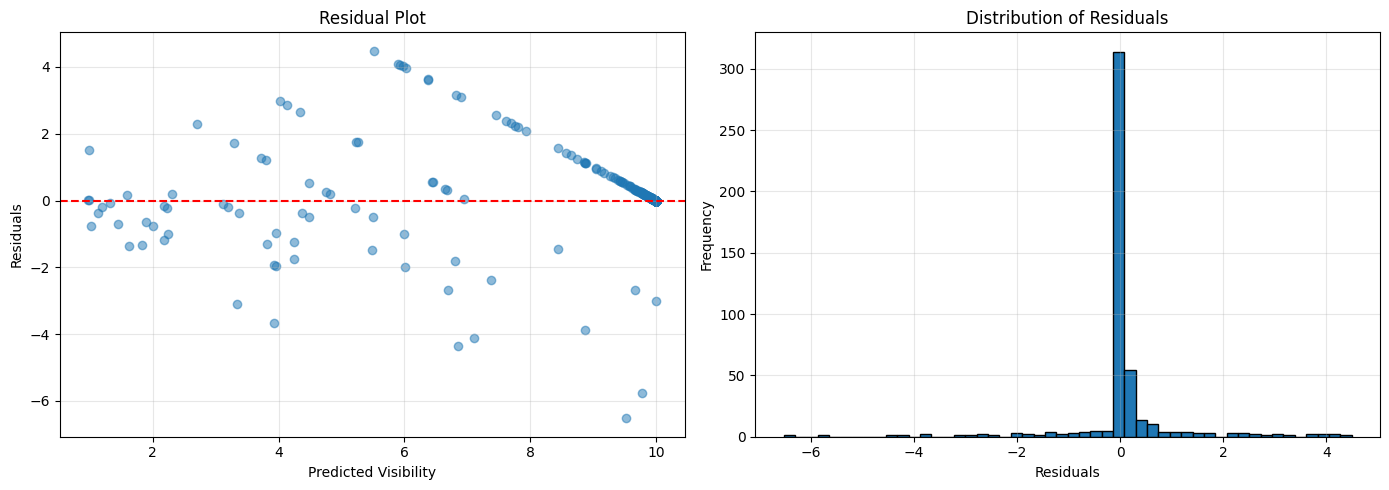

In [18]:
# Residual analysis for the best model (likely Random Forest or Gradient Boosting)
best_pred = rf_pred  # Change to gb_pred if Gradient Boosting performs better
residuals = y_test - best_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(best_pred, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Visibility')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Example predictions
print("\nSample Predictions:")
sample_df = pd.DataFrame({
    'Actual': y_test.head(10).values,
    'LR_Pred': lr_pred[:10],
    'RF_Pred': rf_pred[:10],
    'GB_Pred': gb_pred[:10]
})
print(sample_df)


Sample Predictions:
   Actual    LR_Pred  RF_Pred    GB_Pred
0    10.0   8.305309   9.9400   9.919099
1    10.0   8.914453  10.0000   9.817890
2     4.0   6.170112   5.4900   4.998036
3    10.0   8.949100   9.9700  10.009900
4    10.0   9.460707   9.0400   9.593200
5    10.0   8.697964  10.0000   9.879064
6    10.0   9.042896  10.0000   9.249535
7    10.0   8.410811   5.9025   8.306099
8    10.0  10.243179   9.5800   9.503895
9    10.0  10.097830  10.0000   9.953293


## Conclusion

The notebook trained three regression models for visibility prediction:
1. **Linear Regression**: Simple baseline model
2. **Random Forest**: Ensemble model with good performance
3. **Gradient Boosting**: Advanced ensemble model

The models use weather features like temperature, dew point, relative humidity, wind direction, wind speed, precipitation, altimeter setting, and feels-like temperature to predict visibility in statute miles.

| Metric                         | Meaning                                                                                                      |
| ------------------------------ | ------------------------------------------------------------------------------------------------------------ |
| RMSE (Root Mean Squared Error) | Measures how far predictions are from actual values on average; penalizes large errors more                  |
| MAE (Mean Absolute Error)      | Average absolute difference between predicted and actual values; easy to interpret                           |
| R² Score                       | Fraction of variance explained by the model (1 = perfect, 0 = baseline mean, negative = worse than baseline) |

## Results and Analysis

| Model             | RMSE   | MAE    | R²     | Interpretation                                                            |
| ----------------- | ------ | ------ | ------ | ------------------------------------------------------------------------- |
| Linear Regression | 1.8747 | 1.2826 | 0.3482 | Poor fit; explains only ~35% of variance; high errors                     |
| Random Forest     | 0.9760 | 0.3749 | 0.8233 | Excellent fit; explains ~82% of variance; low prediction error            |
| Gradient Boosting | 0.9968 | 0.5046 | 0.8157 | Very good fit; slightly worse than RF in RMSE/MAE; explains ~82% variance |

1. Linear Regression is weak. Weather prediction is non-linear, so a simple linear model underfits. RMSE ~1.87 → predictions can be off by ~2 units (visibility scale)

2. Random Forest is the best. Lowest RMSE (0.97) and MAE (0.37). Highest R² (0.823) → captures complex patterns in the data. Robust to outliers, non-linear relationships → perfect for METAR features.

3. Gradient Boosting is close. Slightly higher RMSE/MAE, slightly lower R² than RF. Still very strong, good as an alternative